Files available in the dataset directory (/kaggle/input/world-governments-expenditure-dataset-2000-2021):
['WorldExpenditures.csv', 'economie-mondiale.jpg']
Using Colab cache for faster access to the 'world-governments-expenditure-dataset-2000-2021' dataset.
First 5 records:
    Unnamed: 0  Year    Country                                      Sector  \
0           0  2000  Australia                              Total function   
1           1  2000  Australia  Agriculture, forestry, fishing and hunting   
2           2  2000  Australia      Mining, manufacturing and construction   
3           3  2000  Australia                                   Transport   
4           4  2000  Australia                             Fuel and energy   

   Expenditure(million USD)    GDP(%)  
0                153122.633  37.36193  
1                  2195.583   0.53572  
2                   905.018   0.22082  
3                 11417.379   2.78584  
4                  2251.241   0.54930  

Shape: (25733

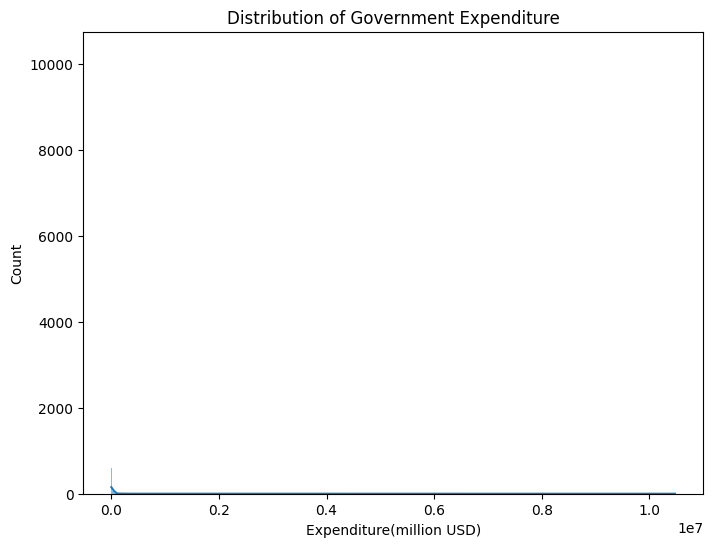

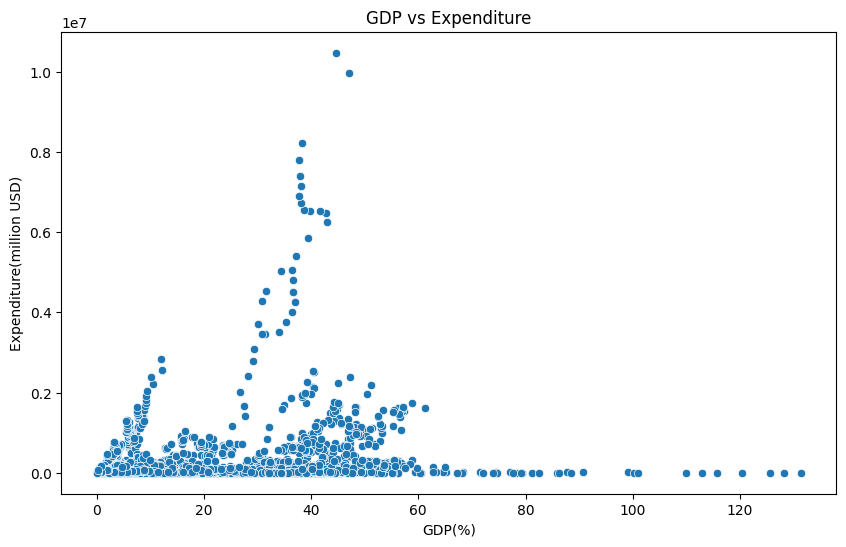

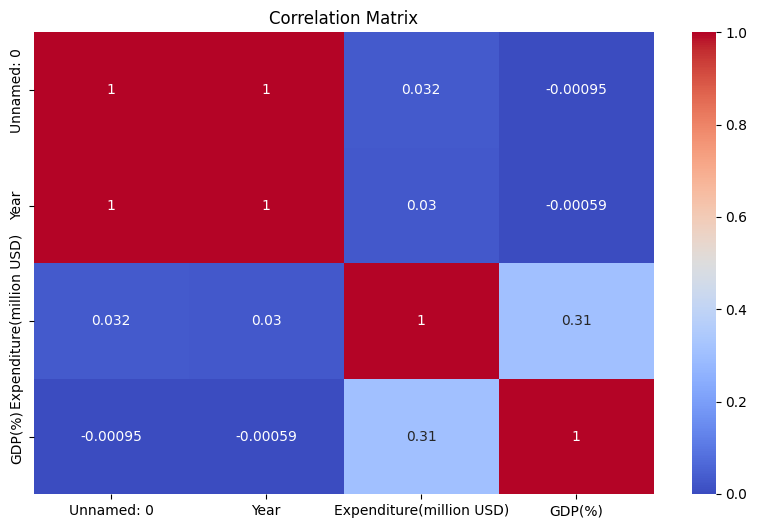


Linear Regression R2 Score: 0.09073345275204503
RMSE: 254353.2936867739

Best Ridge Parameters: {'alpha': 100}

Ensemble R2 Score: 0.09073318139658704
Ensemble RMSE: 254353.33164052328

Model saved as government_expenditure_model.pkl


In [6]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import os module to list directory contents

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor
import joblib   # For model production (saving)

# ================================
# 2. LOADING DATA
# ================================
# List files in the dataset directory to find the correct filename
dataset_path = "/kaggle/input/world-governments-expenditure-dataset-2000-2021"
print(f"Files available in the dataset directory ({dataset_path}):\n{os.listdir(dataset_path)}")

file_path = "WorldExpenditures.csv" # <<<<<<< UPDATE THIS WITH THE CORRECT FILENAME FROM THE LIST ABOVE >>>>>>>
# Example: file_path = "your_actual_data_file.csv"

df = kagglehub.dataset_load( # Changed from load_dataset to dataset_load
    KaggleDatasetAdapter.PANDAS,
    "adamgrey88/world-governments-expenditure-dataset-2000-2021",
    file_path,
)

print("First 5 records:\n", df.head())
print("\nShape:", df.shape)

# ================================
# 3. DATA CLEANING
# ================================
print("\nMissing values:\n", df.isna().sum())

# Example cleaning: drop missing values
df = df.dropna()

# Keep only numeric columns for regression
df_clean = df.select_dtypes(include=np.number)

print("\nAfter cleaning shape:", df_clean.shape)

# ================================
# 4. EXPLORATORY DATA ANALYSIS
# ================================
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['Expenditure(million USD)'], kde=True)
plt.title("Distribution of Government Expenditure")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='GDP(%)', y='Expenditure(million USD)')
plt.title("GDP vs Expenditure")
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# ================================
# 5. MODEL BUILDING
# ================================
X = df_clean[['GDP(%)']]     # independent variable
y = df_clean['Expenditure(million USD)']  # target

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Base Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print("\nLinear Regression R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# ================================
# 6. HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# ================================
param_grid = {
    'alpha': [0.1, 1, 10, 100]
}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("\nBest Ridge Parameters:", grid.best_params_)
best_ridge = grid.best_estimator_

# ================================
# 7. TEST ENSEMBLING (Voting Regressor)
# ================================
lasso = Lasso(alpha=0.1)

ensemble = VotingRegressor([
    ('lr', lin_reg),
    ('ridge', best_ridge),
    ('lasso', lasso),
])

ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)

print("\nEnsemble R2 Score:", r2_score(y_test, y_pred_ensemble))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ensemble)))

# ================================
# 8. PUTTING MODEL INTO PRODUCTION (Save Model)
# ================================
joblib.dump(ensemble, "government_expenditure_model.pkl")

print("\nModel saved as government_expenditure_model.pkl")
